<a href="https://colab.research.google.com/github/antonbeski0/lstm_market_dynamics/blob/main/LSTM_market_dynamics_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing required packages...
★ ENHANCED LSTM STOCK PRICE PREDICTION PIPELINE

⚡ Step 1: Fetching stock data from Yahoo Finance...
   Fetching RELIANCE.NS from 2022-12-06 to 2025-12-05...
   ✓ Fetched 741 trading days for RELIANCE.NS
   ⚠ News sentiment unavailable for RELIANCE.NS
   ✓ Saved RELIANCE.NS (741 rows)
   Fetching TCS.NS from 2022-12-06 to 2025-12-05...
   ✓ Fetched 741 trading days for TCS.NS
   ⚠ News sentiment unavailable for TCS.NS
   ✓ Saved TCS.NS (741 rows)
   Fetching HDFCBANK.NS from 2022-12-06 to 2025-12-05...
   ✓ Fetched 742 trading days for HDFCBANK.NS
   ⚠ News sentiment unavailable for HDFCBANK.NS
   ✓ Saved HDFCBANK.NS (742 rows)
   Fetching INFY.NS from 2022-12-06 to 2025-12-05...
   ✓ Fetched 742 trading days for INFY.NS
   ⚠ News sentiment unavailable for INFY.NS
   ✓ Saved INFY.NS (742 rows)
   Fetching HINDUNILVR.NS from 2022-12-06 to 2025-12-05...
   ✓ Fetched 742 trading days for HINDUNILVR.NS
   ⚠ News sentiment unavailable for HINDUNILVR.NS
   ✓ S

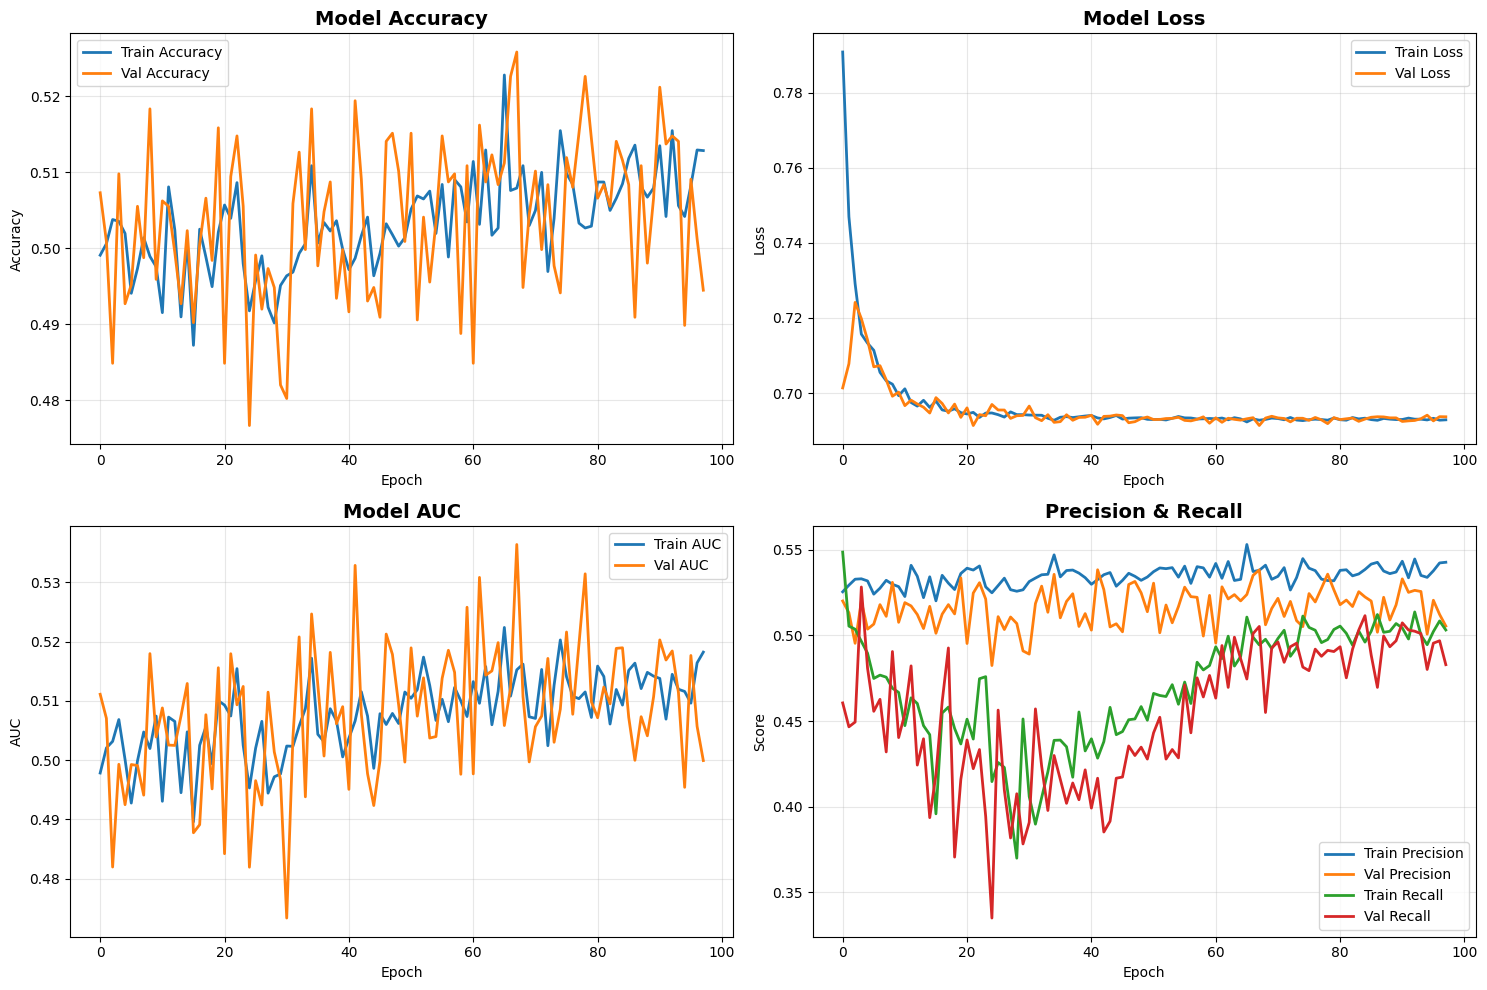

In [1]:
import os
import warnings
import numpy as np
import pandas as pd
import yfinance as yf
from pathlib import Path
from glob import glob
from datetime import datetime, timedelta
from typing import Dict, List, Tuple
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, BatchNormalization, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import mixed_precision
from sklearn.preprocessing import RobustScaler
import matplotlib.pyplot as plt

# Ensure these packages are installed before importing
try:
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from newsapi import NewsApiClient
    import finnhub
except ImportError:
    print("Installing required packages...")
    os.system('pip install vaderSentiment finnhub-python newsapi-python')
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    from newsapi import NewsApiClient
    import finnhub

warnings.filterwarnings('ignore')
mixed_precision.set_global_policy('mixed_float16')

# ==================== CONFIGURATION ====================
CONFIG = {
    "DATA_DIR": Path("TrainingData/indicators_data/processed/stocksData"),
    "FORECAST_DIR": Path("forecasts"),
    "CACHE_DIR": Path("cache"),
    "MODEL_DIR": Path("models"),
    "WINDOW_SIZE": 120,  # Increased for better long-term pattern recognition
    "TRAIN_VAL_FRAC": 0.85,  # More training data
    "VAL_FRAC_WITHIN_TRAIN": 0.15,  # Adjusted validation split
    "MC_DROPOUT_SAMPLES": 30,  # Increased for better uncertainty estimation
    "EXCLUDED_COLS": ["date", "Target1", "NextDayClose", "ticker", "price_change_pct"],
    "PROB_THRESHOLD": 0.60,
    "BATCH_SIZE": 128,  # Larger batch for better gradient estimates
    "EPOCHS": 300,  # More epochs with early stopping
    "LEARNING_RATE": 0.0005,  # Lower learning rate for better convergence

    # API Keys
    "NEWSAPI_KEY": "68234a4ffb2540ac9561e74020f257bb",
    "FINNHUB_KEY": "d4dh9v9r01qovljpqcpgd4dh9v9r01qoljpqcq0",

    # Stock lists
    "NSE_STOCKS": [
        "RELIANCE.NS", "TCS.NS", "HDFCBANK.NS", "INFY.NS", "HINDUNILVR.NS",
        "ICICIBANK.NS", "KOTAKBANK.NS", "SBIN.NS", "BAJFINANCE.NS", "BHARTIARTL.NS",
        "ITC.NS", "ASIANPAINT.NS", "MARUTI.NS", "AXISBANK.NS", "LT.NS"
    ],
    "US_STOCKS": [
        "AAPL", "MSFT", "GOOGL", "AMZN", "NVDA", "META", "TSLA", "BRK-B",
        "UNH", "JNJ", "JPM", "V", "PG", "XOM", "MA"
    ],
}

# Create directories
for dir_path in [CONFIG["DATA_DIR"], CONFIG["FORECAST_DIR"], CONFIG["CACHE_DIR"], CONFIG["MODEL_DIR"]]:
    dir_path.mkdir(parents=True, exist_ok=True)

# ==================== TIMEZONE HANDLING ====================
def normalize_datetime(dt_series: pd.Series) -> pd.Series:
    """Convert all datetime to timezone-naive UTC normalized dates"""
    if dt_series.dt.tz is not None:
        # If timezone-aware, convert to UTC then remove timezone
        return dt_series.dt.tz_convert('UTC').dt.tz_localize(None)
    else:
        # If naive, assume UTC
        return dt_series

def get_date_only(dt_series: pd.Series) -> pd.Series:
    """Extract date only, removing time component"""
    return pd.to_datetime(dt_series.dt.date)

# ==================== MC DROPOUT ====================
class MCDropout(Dropout):
    """Monte Carlo Dropout layer - always enabled during inference"""
    def call(self, inputs, training=None):
        return super().call(inputs, training=True)

def mc_dropout_predict(model, X, n_samples=20):
    """Generate predictions with uncertainty estimates"""
    preds = np.array([model(X, training=True).numpy() for _ in range(n_samples)])
    return preds.mean(axis=0), preds.std(axis=0), preds

# ==================== DATA FETCHING ====================
class DataFetcher:
    def __init__(self):
        try:
            self.newsapi = NewsApiClient(api_key=CONFIG["NEWSAPI_KEY"])
            self.finnhub_client = finnhub.Client(api_key=CONFIG["FINNHUB_KEY"])
            self.vader = SentimentIntensityAnalyzer()
        except Exception as e:
            print(f"⚠ Warning: Could not initialize external APIs: {e}")
            self.newsapi = None
            self.finnhub_client = None
            self.vader = SentimentIntensityAnalyzer()

    def fetch_stock_data(self, ticker: str, start_date: str = None, end_date: str = None) -> pd.DataFrame:
        """Fetch OHLCV data from yfinance with proper timezone handling"""
        try:
            if start_date is None:
                start_date = (datetime.now() - timedelta(days=1095)).strftime("%Y-%m-%d")  # 3 years
            if end_date is None:
                end_date = datetime.now().strftime("%Y-%m-%d")

            print(f"   Fetching {ticker} from {start_date} to {end_date}...")
            stock = yf.Ticker(ticker)
            df = stock.history(start=start_date, end=end_date, auto_adjust=False)

            if df.empty:
                print(f"   ⚠ No data available for {ticker}")
                return pd.DataFrame()

            # Reset index to get date as column
            df = df.reset_index()

            # Normalize column names
            df.columns = [col.lower() for col in df.columns]

            # Handle date column - convert to timezone-naive
            df['date'] = normalize_datetime(df['date'])
            df['date'] = get_date_only(df['date'])

            df['ticker'] = ticker

            # Select and order columns
            result_df = df[['date', 'open', 'high', 'low', 'close', 'volume', 'ticker']].copy()

            # Remove duplicates and sort
            result_df = result_df.drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)

            print(f"   ✓ Fetched {len(result_df)} trading days for {ticker}")
            return result_df

        except Exception as e:
            print(f"   ❌ Error fetching {ticker}: {e}")
            return pd.DataFrame()

    def fetch_news_sentiment(self, ticker: str, days_back: int = 30) -> float:
        """Fetch and analyze news sentiment"""
        if self.newsapi is None or self.vader is None:
            return 0.0

        try:
            company_name = ticker.replace('.NS', '').replace('-', ' ')
            from_date = (datetime.now() - timedelta(days=days_back)).strftime("%Y-%m-%d")

            articles = self.newsapi.get_everything(
                q=company_name,
                from_param=from_date,
                language='en',
                sort_by='relevancy',
                page_size=100
            )

            if not articles.get('articles'):
                return 0.0

            sentiments = []
            for article in articles['articles'][:50]:
                text = f"{article.get('title', '')} {article.get('description', '')}"
                score = self.vader.polarity_scores(text)
                sentiments.append(score['compound'])

            return np.mean(sentiments) if sentiments else 0.0
        except Exception as e:
            print(f"   ⚠ News sentiment unavailable for {ticker}")
            return 0.0

    def fetch_insider_trades(self, ticker: str) -> Dict:
        """Fetch insider trading data from Finnhub"""
        if self.finnhub_client is None:
            return {'insider_buy_ratio': 0.5, 'insider_volume': 0}

        try:
            symbol = ticker.replace('.NS', '').replace('.BO', '')
            trades = self.finnhub_client.stock_insider_transactions(symbol)

            if not trades or 'data' not in trades:
                return {'insider_buy_ratio': 0.5, 'insider_volume': 0}

            buys = sum(1 for t in trades['data'] if t.get('transactionCode') == 'P')
            total = len(trades['data'])
            volume = sum(t.get('share', 0) for t in trades['data'])

            return {
                'insider_buy_ratio': buys / total if total > 0 else 0.5,
                'insider_volume': volume
            }
        except Exception as e:
            return {'insider_buy_ratio': 0.5, 'insider_volume': 0}

# ==================== ENHANCED FEATURE ENGINEERING ====================
def add_technical_indicators(df: pd.DataFrame) -> pd.DataFrame:
    """Add comprehensive technical indicators with improved features"""
    df = df.copy()

    # Basic price features
    df['returns'] = df['close'].pct_change()
    df['log_returns'] = np.log(df['close'] / df['close'].shift(1))
    df['price_range'] = (df['high'] - df['low']) / df['close']

    # Moving averages (more periods for better trend capture)
    for period in [5, 10, 20, 50, 100, 200]:
        df[f'sma_{period}'] = df['close'].rolling(period).mean()
        df[f'ema_{period}'] = df['close'].ewm(span=period, adjust=False).mean()
        df[f'price_to_sma_{period}'] = df['close'] / df[f'sma_{period}']

    # Volatility indicators
    df['volatility_10'] = df['returns'].rolling(10).std()
    df['volatility_20'] = df['returns'].rolling(20).std()
    df['volatility_50'] = df['returns'].rolling(50).std()

    # ATR (Average True Range)
    high_low = df['high'] - df['low']
    high_close = np.abs(df['high'] - df['close'].shift())
    low_close = np.abs(df['low'] - df['close'].shift())
    tr = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    df['atr_14'] = tr.rolling(14).mean()
    df['atr_ratio'] = df['atr_14'] / df['close']

    # RSI with multiple periods
    for period in [7, 14, 21]:
        delta = df['close'].diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        rs = gain / loss
        df[f'rsi_{period}'] = 100 - (100 / (1 + rs))

    # MACD with histogram
    exp1 = df['close'].ewm(span=12, adjust=False).mean()
    exp2 = df['close'].ewm(span=26, adjust=False).mean()
    df['macd'] = exp1 - exp2
    df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
    df['macd_hist'] = df['macd'] - df['macd_signal']
    df['macd_ratio'] = df['macd'] / df['close']

    # Bollinger Bands
    for period in [20, 50]:
        df[f'bb_middle_{period}'] = df['close'].rolling(period).mean()
        bb_std = df['close'].rolling(period).std()
        df[f'bb_upper_{period}'] = df[f'bb_middle_{period}'] + (bb_std * 2)
        df[f'bb_lower_{period}'] = df[f'bb_middle_{period}'] - (bb_std * 2)
        df[f'bb_width_{period}'] = (df[f'bb_upper_{period}'] - df[f'bb_lower_{period}']) / df[f'bb_middle_{period}']
        df[f'bb_position_{period}'] = (df['close'] - df[f'bb_lower_{period}']) / (df[f'bb_upper_{period}'] - df[f'bb_lower_{period}'])

    # Volume indicators
    df['volume_sma_20'] = df['volume'].rolling(20).mean()
    df['volume_sma_50'] = df['volume'].rolling(50).mean()
    df['volume_ratio'] = df['volume'] / df['volume_sma_20']
    df['volume_trend'] = df['volume_sma_20'] / df['volume_sma_50']

    # Momentum indicators
    for period in [5, 10, 20]:
        df[f'momentum_{period}'] = df['close'] - df['close'].shift(period)
        df[f'roc_{period}'] = (df['close'] - df['close'].shift(period)) / df['close'].shift(period) * 100

    # Stochastic Oscillator
    low_14 = df['low'].rolling(14).min()
    high_14 = df['high'].rolling(14).max()
    df['stoch_k'] = 100 * (df['close'] - low_14) / (high_14 - low_14)
    df['stoch_d'] = df['stoch_k'].rolling(3).mean()

    # Price action features
    df['body_size'] = np.abs(df['close'] - df['open']) / df['close']
    df['upper_shadow'] = (df['high'] - df[['open', 'close']].max(axis=1)) / df['close']
    df['lower_shadow'] = (df[['open', 'close']].min(axis=1) - df['low']) / df['close']

    # Lagged features for temporal dependencies
    for lag in [1, 2, 3, 5, 7, 10, 15, 20]:
        df[f'close_lag_{lag}'] = df['close'].shift(lag)
        df[f'volume_lag_{lag}'] = df['volume'].shift(lag)
        df[f'returns_lag_{lag}'] = df['returns'].shift(lag)

    # Rolling statistics
    for window in [5, 10, 20, 50]:
        df[f'close_rolling_mean_{window}'] = df['close'].rolling(window).mean()
        df[f'close_rolling_std_{window}'] = df['close'].rolling(window).std()
        df[f'close_rolling_min_{window}'] = df['close'].rolling(window).min()
        df[f'close_rolling_max_{window}'] = df['close'].rolling(window).max()
        df[f'volume_rolling_mean_{window}'] = df['volume'].rolling(window).mean()

    # Price position in rolling windows
    for window in [10, 20, 50]:
        rolling_min = df['close'].rolling(window).min()
        rolling_max = df['close'].rolling(window).max()
        df[f'price_position_{window}'] = (df['close'] - rolling_min) / (rolling_max - rolling_min + 1e-10)

    # Target variable - next day's closing price (for regression)
    df['NextDayClose'] = df['close'].shift(-1)
    df['Target1'] = (df['NextDayClose'] > df['close']).astype(int)
    df['price_change_pct'] = ((df['NextDayClose'] - df['close']) / df['close']) * 100

    # Clean up
    df.replace([np.inf, -np.inf], np.nan, inplace=True)

    return df

def calculate_adx(df: pd.DataFrame, period: int = 14) -> pd.Series:
    """Calculate Average Directional Index"""
    high_diff = df['high'].diff()
    low_diff = df['low'].diff()

    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)

    atr = df['atr_14'] if 'atr_14' in df.columns else 1

    plus_di = 100 * pd.Series(plus_dm).rolling(period).mean() / atr
    minus_di = 100 * pd.Series(minus_dm).rolling(period).mean() / atr

    dx = 100 * np.abs(plus_di - minus_di) / (plus_di + minus_di)
    adx = dx.rolling(period).mean()

    return adx

def enrich_with_external_data(df: pd.DataFrame, ticker: str, fetcher: DataFetcher) -> pd.DataFrame:
    """Add sentiment and insider trading features"""
    sentiment = fetcher.fetch_news_sentiment(ticker)
    df['news_sentiment'] = sentiment

    insider_data = fetcher.fetch_insider_trades(ticker)
    df['insider_buy_ratio'] = insider_data['insider_buy_ratio']
    df['insider_volume_norm'] = np.log1p(insider_data['insider_volume'])

    return df

# ==================== DATA PROCESSING ====================
def process_stock(csv_path: Path, scaler: RobustScaler, feature_cols: List[str],
                 for_training: bool = True) -> Tuple[np.ndarray, np.ndarray, pd.DataFrame, List[datetime], np.ndarray]:
    """Process a single stock CSV into windowed sequences"""
    df = pd.read_csv(csv_path, parse_dates=['date'])
    df = df.dropna(subset=['date'])

    if df.empty or len(df) < CONFIG["WINDOW_SIZE"] + 1:
        return np.array([]), np.array([]), df, [], np.array([])

    # Normalize dates
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = get_date_only(df['date'])

    df = df.sort_values('date').reset_index(drop=True)

    # Ensure all feature columns exist
    for col in feature_cols:
        if col not in df.columns:
            df[col] = 0.0

    # Handle any remaining NaN values
    df[feature_cols] = df[feature_cols].fillna(method='ffill').fillna(method='bfill').fillna(0)

    # Scale features
    features_scaled = scaler.transform(df[feature_cols].values)
    dates_list = df['date'].tolist()
    target = df['Target1'].values if for_training else None
    closes = df['close'].values

    # Create sequences
    X, y, y_dates, y_closes = [], [], [], []
    for i in range(CONFIG["WINDOW_SIZE"], len(features_scaled)):
        X.append(features_scaled[i - CONFIG["WINDOW_SIZE"]:i])
        if for_training and target is not None:
            y.append(target[i])
        y_dates.append(dates_list[i])
        y_closes.append(closes[i])

    return (
        np.array(X, dtype=np.float32),
        np.array(y, dtype=np.float32) if for_training else None,
        df,
        y_dates,
        np.array(y_closes, dtype=np.float32)
    )

def cache_preprocessed_stock(csv_path: Path, scaler: RobustScaler, feature_cols: List[str],
                            train_cutoff: datetime, train_val_cutoff: datetime):
    """Cache preprocessed data for faster training"""
    stock_name = csv_path.stem
    print(f"   Caching: {stock_name}")

    X, y, _, y_dates, y_closes = process_stock(csv_path, scaler, feature_cols, for_training=True)

    if X.size == 0:
        for split in ['train', 'val', 'test']:
            np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_X_{split}.npy", np.array([]))
            np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_y_{split}.npy", np.array([]))
            np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_y_closes_{split}.npy", np.array([]))
        return

    y_dates_series = pd.Series(pd.to_datetime(y_dates))

    splits = {
        'train': y_dates_series < train_cutoff,
        'val': (y_dates_series >= train_cutoff) & (y_dates_series < train_val_cutoff),
        'test': y_dates_series >= train_val_cutoff
    }

    for split, mask in splits.items():
        np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_X_{split}.npy", X[mask])
        np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_y_{split}.npy", y[mask])
        np.save(CONFIG["CACHE_DIR"] / f"{stock_name}_y_closes_{split}.npy", y_closes[mask])

    print(f"      ✓ {stock_name}: " + ", ".join([f"{s}={np.sum(m)}" for s, m in splits.items()]))

# ==================== DATA GENERATOR ====================
class WeightedStockDataGenerator(tf.keras.utils.Sequence):
    """Memory-efficient batch generator with class balancing"""
    def __init__(self, stock_files: List[Path], split: str, batch_size: int = 32, shuffle: bool = True):
        self.split = split
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Build index with class labels for balancing
        self.windows = []
        class_0_count = 0
        class_1_count = 0

        for csv_path in stock_files:
            stock_name = csv_path.stem
            X_file = CONFIG["CACHE_DIR"] / f"{stock_name}_X_{split}.npy"
            y_file = CONFIG["CACHE_DIR"] / f"{stock_name}_y_{split}.npy"

            if X_file.exists() and y_file.exists():
                X = np.load(X_file, mmap_mode='r')
                y = np.load(y_file, mmap_mode='r')

                if len(X) > 0 and len(y) > 0:
                    for i in range(len(X)):
                        self.windows.append((stock_name, i, y[i]))
                        if y[i] == 0:
                            class_0_count += 1
                        else:
                            class_1_count += 1

        # Calculate class weights for balanced sampling
        total = class_0_count + class_1_count
        if total > 0:
            self.class_weight_0 = total / (2 * class_0_count) if class_0_count > 0 else 1.0
            self.class_weight_1 = total / (2 * class_1_count) if class_1_count > 0 else 1.0
            print(f"      Class distribution - 0: {class_0_count}, 1: {class_1_count}")
            print(f"      Class weights - 0: {self.class_weight_0:.3f}, 1: {self.class_weight_1:.3f}")
        else:
            self.class_weight_0 = 1.0
            self.class_weight_1 = 1.0

        self.indices = np.arange(len(self.windows))
        self.on_epoch_end()

    def __len__(self):
        return max(1, int(np.ceil(len(self.windows) / self.batch_size)))

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_batch, y_batch, weights_batch = [], [], []
        cache = {}

        for bi in batch_indices:
            stock_name, win_idx, label = self.windows[bi]
            if stock_name not in cache:
                X = np.load(CONFIG["CACHE_DIR"] / f"{stock_name}_X_{self.split}.npy", mmap_mode='r')
                y = np.load(CONFIG["CACHE_DIR"] / f"{stock_name}_y_{self.split}.npy", mmap_mode='r')
                cache[stock_name] = (X, y)
            else:
                X, y = cache[stock_name]

            X_batch.append(X[win_idx])
            y_batch.append(y[win_idx])
            # Add sample weight based on class
            weight = self.class_weight_1 if y[win_idx] == 1 else self.class_weight_0
            weights_batch.append(weight)

        return (
            np.array(X_batch, dtype=np.float32),
            np.array(y_batch, dtype=np.float32),
            np.array(weights_batch, dtype=np.float32)
        )

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)

# ==================== ENHANCED MODEL BUILDING ====================
def build_model(input_shape: Tuple[int, int]) -> Sequential:
    """Build advanced LSTM model with attention-like mechanism and deep architecture"""
    model = Sequential([
        # Multi-scale convolutional feature extraction
        Conv1D(128, kernel_size=3, activation='relu', padding='same', input_shape=input_shape),
        BatchNormalization(),
        MCDropout(0.25),

        Conv1D(128, kernel_size=5, activation='relu', padding='same'),
        BatchNormalization(),
        MCDropout(0.25),

        # Deep bidirectional LSTM stack with residual-like connections
        Bidirectional(LSTM(256, return_sequences=True)),
        BatchNormalization(),
        MCDropout(0.3),

        Bidirectional(LSTM(128, return_sequences=True)),
        BatchNormalization(),
        MCDropout(0.3),

        Bidirectional(LSTM(64, return_sequences=False)),
        BatchNormalization(),
        MCDropout(0.3),

        # Deep dense layers with progressive dimension reduction
        Dense(128, activation='relu'),
        BatchNormalization(),
        MCDropout(0.25),

        Dense(64, activation='relu'),
        BatchNormalization(),
        MCDropout(0.25),

        Dense(32, activation='relu'),
        BatchNormalization(),
        MCDropout(0.2),

        Dense(16, activation='relu'),
        MCDropout(0.2),

        Dense(1, activation='sigmoid', dtype='float32')
    ])

    # Custom optimizer with gradient clipping
    optimizer = tf.keras.optimizers.Adam(
        learning_rate=CONFIG["LEARNING_RATE"],
        clipnorm=1.0,  # Gradient clipping for stability
        beta_1=0.9,
        beta_2=0.999
    )

    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=[
            'accuracy',
            tf.keras.metrics.AUC(name='auc'),
            tf.keras.metrics.Precision(name='precision'),
            tf.keras.metrics.Recall(name='recall'),
            tf.keras.metrics.TruePositives(name='tp'),
            tf.keras.metrics.TrueNegatives(name='tn'),
            tf.keras.metrics.FalsePositives(name='fp'),
            tf.keras.metrics.FalseNegatives(name='fn')
        ]
    )

    return model

# ==================== FORECASTING ====================
def make_forecast(model: Sequential, X: np.ndarray, dates: List[datetime],
                 closes: np.ndarray) -> pd.DataFrame:
    """Generate predictions with uncertainty estimates"""
    y_pred_mean, y_pred_std, _ = mc_dropout_predict(model, X, n_samples=CONFIG["MC_DROPOUT_SAMPLES"])

    predictions_df = pd.DataFrame({
        'Date': dates,
        'Current_Close': closes,
        'Prob_Up': y_pred_mean.flatten(),
        'Uncertainty': y_pred_std.flatten(),
        'Predicted_Direction': ['UP' if p > 0.5 else 'DOWN' for p in y_pred_mean.flatten()],
        'Confidence': [abs(p - 0.5) * 2 for p in y_pred_mean.flatten()],
        'Signal': ['BUY' if p > CONFIG["PROB_THRESHOLD"] else
                  'SELL' if p < (1 - CONFIG["PROB_THRESHOLD"]) else 'HOLD'
                  for p in y_pred_mean.flatten()]
    })

    return predictions_df

# ==================== MAIN PIPELINE ====================
def main():
    print("=" * 70)
    print("★ ENHANCED LSTM STOCK PRICE PREDICTION PIPELINE")
    print("=" * 70)

    # Step 1: Fetch Data
    print("\n⚡ Step 1: Fetching stock data from Yahoo Finance...")
    fetcher = DataFetcher()
    all_tickers = CONFIG["NSE_STOCKS"] + CONFIG["US_STOCKS"]

    for ticker in all_tickers:
        csv_path = CONFIG["DATA_DIR"] / f"{ticker.replace('.', '_')}.csv"

        if not csv_path.exists():
            df = fetcher.fetch_stock_data(ticker)
            if not df.empty:
                df = add_technical_indicators(df)
                df = enrich_with_external_data(df, ticker, fetcher)
                # Remove rows with NaN in critical columns before saving
                df = df.dropna(subset=['close', 'open', 'high', 'low', 'volume', 'Target1'])
                df.to_csv(csv_path, index=False)
                print(f"   ✓ Saved {ticker} ({len(df)} rows)")
        else:
            print(f"   ✓ {ticker} already cached")

    # Step 2: Fit Scaler & Determine Date Ranges
    print("\n⚙ Step 2: Fitting robust scaler on all data...")
    all_csvs = sorted(glob(str(CONFIG["DATA_DIR"] / "*.csv")))

    global_min_date, global_max_date = None, None
    scaler_inputs = []
    feature_cols = None

    for csv_path in all_csvs:
        df_tmp = pd.read_csv(csv_path, parse_dates=['date'])
        df_tmp = df_tmp.dropna(subset=['date'])

        if df_tmp.empty:
            continue

        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp['date'] = get_date_only(df_tmp['date'])

        if global_min_date is None or df_tmp['date'].min() < global_min_date:
            global_min_date = df_tmp['date'].min()
        if global_max_date is None or df_tmp['date'].max() > global_max_date:
            global_max_date = df_tmp['date'].max()

        if feature_cols is None:
            feature_cols = [c for c in df_tmp.columns if c not in CONFIG["EXCLUDED_COLS"]]

        df_tmp_cleaned = df_tmp.dropna(subset=feature_cols)
        if not df_tmp_cleaned.empty:
            scaler_inputs.append(df_tmp_cleaned[feature_cols].values)

    scaler = RobustScaler()
    scaler.fit(np.vstack(scaler_inputs))

    print(f"   ✓ Features: {len(feature_cols)}")
    print(f"   ✓ Date range: {global_min_date.date()} to {global_max_date.date()}")
    print(f"   ✓ Total days: {(global_max_date - global_min_date).days}")

    # Step 3: Cache Preprocessed Data
    print("\n☁ Step 3: Caching preprocessed data with timezone-normalized dates...")
    train_val_cutoff = global_min_date + (global_max_date - global_min_date) * CONFIG["TRAIN_VAL_FRAC"]
    train_cutoff = global_min_date + (train_val_cutoff - global_min_date) * (1 - CONFIG["VAL_FRAC_WITHIN_TRAIN"])

    print(f"   Train cutoff: {train_cutoff.date()}")
    print(f"   Validation cutoff: {train_val_cutoff.date()}")

    for csv_path in all_csvs:
        cache_preprocessed_stock(Path(csv_path), scaler, feature_cols, train_cutoff, train_val_cutoff)

    # Step 4: Create Data Generators
    print("\n♻ Step 4: Creating weighted data generators...")
    train_gen = WeightedStockDataGenerator([Path(p) for p in all_csvs], 'train', CONFIG["BATCH_SIZE"], shuffle=True)
    val_gen = WeightedStockDataGenerator([Path(p) for p in all_csvs], 'val', CONFIG["BATCH_SIZE"], shuffle=False)

    print(f"   ✓ Train batches: {len(train_gen)}")
    print(f"   ✓ Validation batches: {len(val_gen)}")
    print(f"   ✓ Train samples: {len(train_gen.windows)}")
    print(f"   ✓ Validation samples: {len(val_gen.windows)}")

    # Step 5: Build & Train Model
    print("\n⚗ Step 5: Building and training enhanced model...")
    n_features = len(feature_cols)
    model = build_model((CONFIG["WINDOW_SIZE"], n_features))

    print(f"   ✓ Model parameters: {model.count_params():,}")

    callbacks = [
        EarlyStopping(
            monitor='val_auc',  # Monitor AUC instead of loss
            patience=30,
            restore_best_weights=True,
            verbose=1,
            mode='max'
        ),
        ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.3,
            patience=10,
            verbose=1,
            min_lr=1e-8,
            cooldown=5
        ),
        ModelCheckpoint(
            filepath=str(CONFIG["MODEL_DIR"] / "best_model.keras"),
            monitor='val_auc',
            save_best_only=True,
            verbose=1,
            mode='max'
        ),
        tf.keras.callbacks.CSVLogger(
            str(CONFIG["MODEL_DIR"] / "training_log.csv"),
            append=False
        )
    ]

    # Train with sample weights
    print(f"   Training with {CONFIG['EPOCHS']} epochs...")
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG["EPOCHS"],
        callbacks=callbacks,
        verbose=1
    )

    # Plot training history
    plt.figure(figsize=(15, 10))

    # Accuracy plot
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    plt.plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    plt.title('Model Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Loss plot
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss', linewidth=2)
    plt.plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    plt.title('Model Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # AUC plot
    plt.subplot(2, 2, 3)
    plt.plot(history.history['auc'], label='Train AUC', linewidth=2)
    plt.plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    plt.title('Model AUC', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # Precision & Recall plot
    plt.subplot(2, 2, 4)
    plt.plot(history.history['precision'], label='Train Precision', linewidth=2)
    plt.plot(history.history['val_precision'], label='Val Precision', linewidth=2)
    plt.plot(history.history['recall'], label='Train Recall', linewidth=2)
    plt.plot(history.history['val_recall'], label='Val Recall', linewidth=2)
    plt.title('Precision & Recall', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    print("   ✓ Training history saved to training_history.png")

    # Step 6: Generate Forecasts
    print("\n📊 Step 6: Generating forecasts for test period...")

    # Clear old forecasts
    for file in glob(str(CONFIG["FORECAST_DIR"] / "*.csv")):
        os.remove(file)

    forecast_summary = []

    for csv_path in all_csvs:
        stock_name = Path(csv_path).stem
        ticker = stock_name.replace('_', '.')

        X_all, _, df, y_dates, y_closes = process_stock(
            Path(csv_path), scaler, feature_cols, for_training=False
        )

        if X_all.size == 0:
            print(f"   ⚠ Skipping {stock_name} (insufficient data)")
            continue

        y_dates_series = pd.Series(pd.to_datetime(y_dates))
        test_mask = y_dates_series >= train_val_cutoff

        if not np.any(test_mask):
            print(f"   ⚠ Skipping {stock_name} (no test data)")
            continue

        # Generate predictions
        forecast_df = make_forecast(
            model,
            X_all[test_mask],
            y_dates_series[test_mask].tolist(),
            y_closes[test_mask]
        )

        # Save individual forecast
        forecast_path = CONFIG["FORECAST_DIR"] / f"{stock_name}_forecast.csv"
        forecast_df.to_csv(forecast_path, index=False)

        # Calculate summary statistics
        buy_signals = (forecast_df['Signal'] == 'BUY').sum()
        sell_signals = (forecast_df['Signal'] == 'SELL').sum()
        hold_signals = (forecast_df['Signal'] == 'HOLD').sum()
        avg_confidence = forecast_df['Confidence'].mean()

        forecast_summary.append({
            'Ticker': ticker,
            'Predictions': len(forecast_df),
            'BUY_Signals': buy_signals,
            'SELL_Signals': sell_signals,
            'HOLD_Signals': hold_signals,
            'Avg_Confidence': f"{avg_confidence:.2%}",
            'Latest_Signal': forecast_df.iloc[-1]['Signal'],
            'Latest_Prob_Up': f"{forecast_df.iloc[-1]['Prob_Up']:.2%}",
            'Latest_Date': forecast_df.iloc[-1]['Date'].strftime('%Y-%m-%d')
        })

        print(f"   ✓ {stock_name}: {len(forecast_df)} predictions | "
              f"Latest: {forecast_df.iloc[-1]['Signal']} "
              f"({forecast_df.iloc[-1]['Prob_Up']:.1%} ↑)")

    # Save summary report
    summary_df = pd.DataFrame(forecast_summary)
    summary_df.to_csv(CONFIG["FORECAST_DIR"] / "_SUMMARY_REPORT.csv", index=False)

    print("\n" + "=" * 70)
    print("✅ PIPELINE COMPLETED SUCCESSFULLY!")
    print("=" * 70)
    print(f"\n📁 Results saved to:")
    print(f"   • Forecasts: {CONFIG['FORECAST_DIR'].absolute()}")
    print(f"   • Model: {CONFIG['MODEL_DIR'].absolute()}")
    print(f"   • Training plot: training_history.png")
    print(f"\n📈 Summary Statistics:")
    print(f"   • Total stocks processed: {len(forecast_summary)}")
    print(f"   • Total predictions generated: {summary_df['Predictions'].sum()}")
    print(f"   • Average confidence: {summary_df['Avg_Confidence'].str.rstrip('%').astype(float).mean():.2f}%")

    print("\n🎯 Latest Signals:")
    for _, row in summary_df.iterrows():
        signal_icon = "🟢" if row['Latest_Signal'] == 'BUY' else "🔴" if row['Latest_Signal'] == 'SELL' else "🟡"
        print(f"   {signal_icon} {row['Ticker']:12} {row['Latest_Signal']:4} (Prob: {row['Latest_Prob_Up']:6}) on {row['Latest_Date']}")

    print("\n" + "=" * 70)

if __name__ == "__main__":
    main()